In [ ]:
import time
import os
import cv2
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from PIL import Image
import shutil
import zipfile

num_workers = 4 #change this parameter based on your system configuration
batch_size = 32 #change this parameter based on your system configuration
seed = 24
random.seed(seed)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
num_classes = len(categories)
splits = ['train', 'val', 'test']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/SEM7/image processing/individual project')

Mounted at /content/drive


For first time to unzip the dataset uploaded

In [ ]:
# local_zip = 'COVID-19_Radiography_Dataset.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall()
# zip_ref.close()

In [ ]:
DATA_PATH = 'COVID-19_Radiography_Dataset'

Split original test folder randomly and equaly between test and validation (new) folders

In [ ]:
if not os.path.isdir(os.path.join(DATA_PATH, 'val')):
    os.mkdir(os.path.join(DATA_PATH, 'val'))
    for subdir in categories:   
        for root, dirs, files in os.walk(os.path.join(DATA_PATH, 'test/'+subdir)):
            size = len(files)
            migrate_index = random.sample(range(size), int(size/2))
            files_to_migrate = [files[i] for i in migrate_index]
            for file in files_to_migrate:
                file_path = os.path.join(DATA_PATH, 'test/' + subdir + '/' + file)
                new_dir = os.path.join(DATA_PATH, 'val/' + subdir)
                if not os.path.exists(new_dir):
                    os.mkdir(new_dir)
                if not os.path.exists(os.path.join(new_dir, file)):
                    a = shutil.move(file_path, new_dir)
else: print("Folder 'val' is already available and the split didn't happen")

Folder 'val' is already available and the split didn't happen


In [ ]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','3','']
    print(df)
    return df
df_dataset = show_dataset()

                code train  val test  total
COVID              0   400   50   50    500
Lung_Opacity       1   400   50   50    500
Normal             2   400   50   50    500
Viral_Pneumonia    3   400   50   50    500
TOTAL                 1600  200  200   2000


In [ ]:
def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
                                    [transforms.Resize(299),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform_dict['model'])
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(dataset)

2000

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


Show images from training datasets

Class: COVID


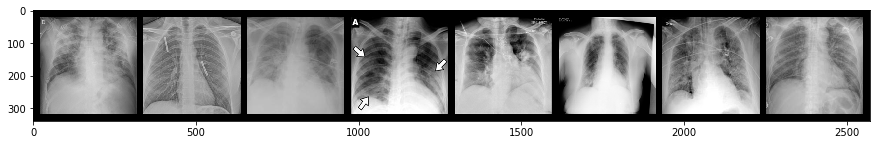

Class: Lung_Opacity


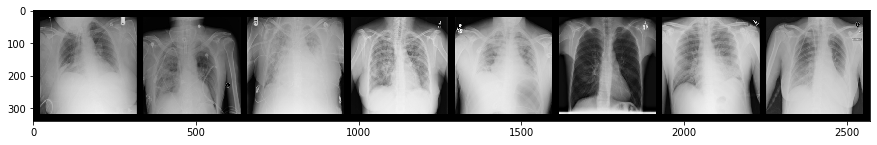

Class: Normal


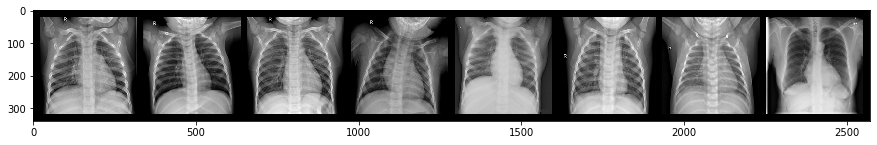

Class: Viral_Pneumonia


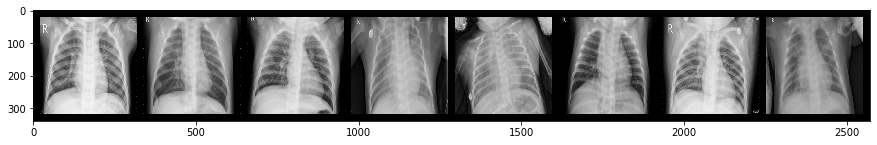

In [ ]:
def show_batch_images(dataset):
    n_images, scale = 8, 3
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle = True)
    images, labels = next(iter(data_loader))
    for i in range(len(categories)):
        print(f'Class: {categories[i]}')
        images_category = images[labels==i][:n_images]
        grid = torchvision.utils.make_grid(images_category, padding=20)
        npgrid = grid.cpu().numpy()
        plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
        plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        plt.show()
        #plt.savefig('x-ray[i].pdf')  
        #plt.savefig("viz1.png", bbox_inches='tight')

show_batch_images(train_data)

In [ ]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

In [ ]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    return predictions, actuals

def train_val_model(model):
    t_start = time.time()
    global best_val_model
    global best_val_loss
    best_val_loss = 1
    global best_val_epoch
    best_val_epoch = 0
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size]
        if epoch >= best_val_epoch + 15:
            break
        if use_scheduler: scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
    #print(f"Best model has val loss={best_val_loss:.5f} for {best_val_epoch} epochs")
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def train_val_model_kfold(model, train_loader_kfold):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train'])
    print(f"Training model with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs")
    train_size = len(train_loader_kfold)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        #model.train()
        train_loss = 0.0
        for i, (data, target) in enumerate(train_loader_kfold):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size]
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def accuracy_model(model, loader):
    model.eval()
    print(f"Testing the model with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

In [ ]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet34":
        model_ft = models.resnet34(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet50":
        model_ft = models.resnet50(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet101":
        model_ft = models.resnet101(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg16":
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "vgg19":
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "EfficientNet":
        from efficientnet_pytorch import EfficientNet
        model_ft = EfficientNet.from_pretrained('efficientnet-b7',num_classes=num_classes)

    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
            #param.aux_logits = False    
        #num_ftrs = model_ft.fc.in_features
        #model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        model_ft.aux_logits = False
    
    else:
        print("Invalid model name, exiting...")
        exit()
    
    model_ft.to(device)
    return model_ft

Import and initialize models

In [ ]:
model_list = ["inception","resnet50","vgg16"]
all_models = []
for model in model_list:
  all_models.append(initialize_model(model, num_classes, use_pretrained=True))

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
pretrained_model_list = []
df_epochs_list = []
for model_name, pre_model in zip(model_list,all_models):
  n_epochs = 20
  learning_rate = 1e-2
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(pre_model.parameters(), lr=learning_rate)
  use_scheduler = False   # Set True if using scheduler
  pretrained_model, df_epochs = train_val_model(pre_model)
  pretrained_model_list.append(pretrained_model)
  df_epochs_list.append(df_epochs)

Training model inception with 1600 samples and max of 20 epochs, and validating with 200 samples



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1:	 train loss=1.21621 	 val loss=1.05469 	 time=19.01s
Epoch 2:	 train loss=0.95700 	 val loss=0.83288 	 time=18.88s
Epoch 3:	 train loss=0.84381 	 val loss=0.73891 	 time=18.88s
Epoch 4:	 train loss=0.75029 	 val loss=0.68207 	 time=19.00s
Epoch 5:	 train loss=0.70134 	 val loss=0.64938 	 time=19.13s
Epoch 6:	 train loss=0.66720 	 val loss=0.60722 	 time=19.13s
Epoch 7:	 train loss=0.64084 	 val loss=0.57058 	 time=19.22s
Epoch 8:	 train loss=0.62775 	 val loss=0.55028 	 time=19.22s
Epoch 9:	 train loss=0.57832 	 val loss=0.53951 	 time=19.16s
Epoch 10:	 train loss=0.56798 	 val loss=0.51909 	 time=19.19s
Epoch 11:	 train loss=0.58235 	 val loss=0.52105 	 time=18.94s
Epoch 12:	 train loss=0.54513 	 val loss=0.51965 	 time=19.22s
Epoch 13:	 train loss=0.56283 	 val loss=0.49030 	 time=19.04s
Epoch 14:	 train loss=0.52512 	 val loss=0.47922 	 time=19.08s
Epoch 15:	 train loss=0.51860 	 val loss=0.48478 	 time=18.99s
Total time training and evaluating: 286.20s
Training model resne

inception


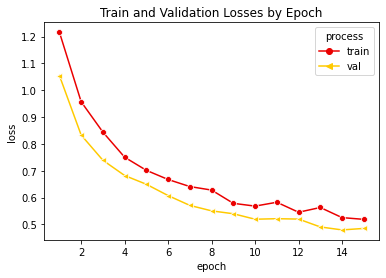

resnet50


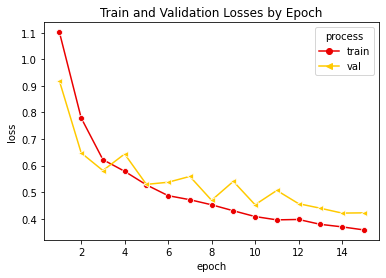

vgg16


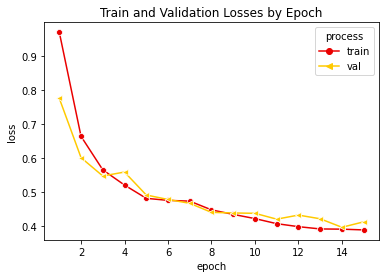

In [ ]:
for ep,name in zip(df_epochs_list,model_list):
  print(name)
  plot_train_val_losses(ep)

In [ ]:
confusions = []
for pre,name in zip(pretrained_model_list,model_list):
  print(name)
  test_inception_results, conf_inception_matrix_test = accuracy_model(pre, test_loader)
  confusions.append(conf_inception_matrix_test)

inception
Testing the model with 200 samples 



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              Accuracy  Precision  Recall  F1-score
Test Results      0.84   0.842854    0.84  0.839889
resnet50
Testing the model with 200 samples 



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              Accuracy  Precision  Recall  F1-score
Test Results     0.895   0.897575   0.895  0.894333
vgg16
Testing the model with 200 samples 



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              Accuracy  Precision  Recall  F1-score
Test Results      0.88    0.88482    0.88  0.878175


inception


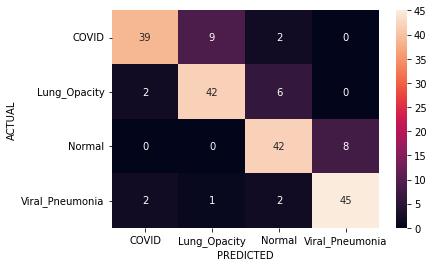

In [ ]:
print(model_list[0])
sns.heatmap(confusions[0], annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

resnet50


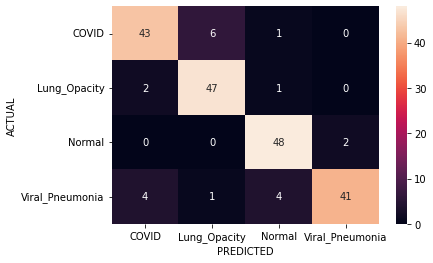

In [ ]:
print(model_list[1])
sns.heatmap(confusions[1], annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

vgg16


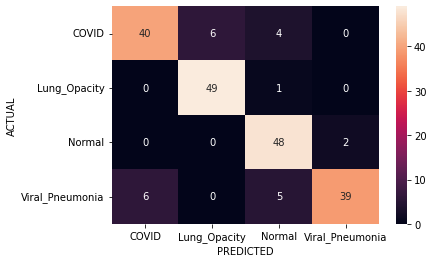

In [ ]:
print(model_list[2])
sns.heatmap(confusions[2], annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

In [ ]:
from sklearn.model_selection import KFold
def validate_model_kfold(model, model_name, k_folds):
    #model.eval()
    print(f"Validating the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {k_folds}-folds \n")
    df = pd.DataFrame(columns = metrics)
    kfold = KFold(n_splits=k_folds, shuffle=True)
    print(len(dataset))
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        train_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_subsampler)
        test_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_subsampler)
        #model.apply(reset_weights)
        model, df_vgg_epochs = train_val_model_kfold(model, train_kfold_loader)
        predictions, actuals = calc_pred_actuals(model, test_kfold_loader)
        conf_matrix = create_confusion_matrix(predictions, actuals)
        df_aux = calc_metrics(predictions, actuals, 'FOLD '+str(fold+1))
        df = df.append(df_aux)      
    df.loc['Average'] = df.mean(axis=0)
    print(df.astype(float))
    return df.astype(float), conf_matrix

In [ ]:
validation_our_model_results, conf_matrix_our_model_val = validate_model_kfold(all_models[2], model_name = model_list[2], k_folds = 5)

Validating the model vgg16 with 1600 samples and 5-folds 

2000
Training model with 1600 samples and max of 20 epochs


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1:	 train loss=0.29611 	 time=45.23s
Epoch 2:	 train loss=0.28783 	 time=45.23s
Epoch 3:	 train loss=0.28151 	 time=45.05s
Epoch 4:	 train loss=0.27489 	 time=45.11s
Epoch 5:	 train loss=0.26917 	 time=45.12s
Epoch 6:	 train loss=0.26395 	 time=45.32s
Epoch 7:	 train loss=0.25861 	 time=45.03s
Epoch 8:	 train loss=0.25591 	 time=45.00s
Epoch 9:	 train loss=0.25027 	 time=45.00s
Epoch 10:	 train loss=0.24662 	 time=45.04s
Epoch 11:	 train loss=0.24241 	 time=45.02s
Epoch 12:	 train loss=0.23808 	 time=45.05s
Epoch 13:	 train loss=0.23569 	 time=44.95s
Epoch 14:	 train loss=0.23119 	 time=44.83s
Epoch 15:	 train loss=0.22937 	 time=44.93s
Epoch 16:	 train loss=0.22700 	 time=44.47s
Epoch 17:	 train loss=0.22180 	 time=44.90s
Epoch 18:	 train loss=0.21753 	 time=44.95s
Epoch 19:	 train loss=0.21730 	 time=44.82s
Epoch 20:	 train loss=0.21424 	 time=44.85s
Total time training and evaluating: 900.04s
Training model with 1600 samples and max of 20 epochs


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1:	 train loss=0.24480 	 time=45.02s
Epoch 2:	 train loss=0.23808 	 time=45.00s
Epoch 3:	 train loss=0.23369 	 time=45.01s
Epoch 4:	 train loss=0.23020 	 time=44.97s
Epoch 5:	 train loss=0.22642 	 time=44.89s
Epoch 6:	 train loss=0.22299 	 time=44.99s
Epoch 7:	 train loss=0.22202 	 time=45.00s
Epoch 8:	 train loss=0.21586 	 time=44.91s
Epoch 9:	 train loss=0.21467 	 time=44.89s
Epoch 10:	 train loss=0.21238 	 time=45.00s
Epoch 11:	 train loss=0.21035 	 time=44.99s
Epoch 12:	 train loss=0.20720 	 time=44.91s
Epoch 13:	 train loss=0.20388 	 time=44.90s
Epoch 14:	 train loss=0.20152 	 time=44.96s
Epoch 15:	 train loss=0.19953 	 time=44.91s
Epoch 16:	 train loss=0.19681 	 time=44.91s
Epoch 17:	 train loss=0.19450 	 time=44.98s
Epoch 18:	 train loss=0.19372 	 time=44.91s
Epoch 19:	 train loss=0.19169 	 time=44.99s
Epoch 20:	 train loss=0.18882 	 time=44.99s
Total time training and evaluating: 899.23s
Training model with 1600 samples and max of 20 epochs


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1:	 train loss=0.19524 	 time=44.80s
Epoch 2:	 train loss=0.19148 	 time=44.87s
Epoch 3:	 train loss=0.18828 	 time=44.98s
Epoch 4:	 train loss=0.18602 	 time=44.95s
Epoch 5:	 train loss=0.18322 	 time=44.96s
Epoch 6:	 train loss=0.18151 	 time=44.85s
Epoch 7:	 train loss=0.17981 	 time=44.95s
Epoch 8:	 train loss=0.17799 	 time=44.91s
Epoch 9:	 train loss=0.17532 	 time=44.88s
Epoch 10:	 train loss=0.17293 	 time=44.88s
Epoch 11:	 train loss=0.17212 	 time=44.84s
Epoch 12:	 train loss=0.16993 	 time=44.86s
Epoch 13:	 train loss=0.16705 	 time=44.82s
Epoch 14:	 train loss=0.16669 	 time=44.97s
Epoch 15:	 train loss=0.16469 	 time=44.97s
Epoch 16:	 train loss=0.16319 	 time=44.91s
Epoch 17:	 train loss=0.16072 	 time=44.93s
Epoch 18:	 train loss=0.16127 	 time=44.88s
Epoch 19:	 train loss=0.15868 	 time=44.97s
Epoch 20:	 train loss=0.15666 	 time=45.00s
Total time training and evaluating: 898.31s
Training model with 1600 samples and max of 20 epochs


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1:	 train loss=0.16958 	 time=44.97s
Epoch 2:	 train loss=0.16674 	 time=45.05s
Epoch 3:	 train loss=0.16615 	 time=45.03s
Epoch 4:	 train loss=0.16350 	 time=44.94s
Epoch 5:	 train loss=0.16111 	 time=44.93s
Epoch 6:	 train loss=0.15931 	 time=44.86s
Epoch 7:	 train loss=0.15827 	 time=45.06s
Epoch 8:	 train loss=0.15618 	 time=45.12s
Epoch 9:	 train loss=0.15496 	 time=44.92s
Epoch 10:	 train loss=0.15444 	 time=45.00s
Epoch 11:	 train loss=0.15202 	 time=44.96s
Epoch 12:	 train loss=0.15065 	 time=44.85s
Epoch 13:	 train loss=0.14970 	 time=44.86s
Epoch 14:	 train loss=0.14810 	 time=45.08s
Epoch 15:	 train loss=0.14691 	 time=44.88s
Epoch 16:	 train loss=0.14547 	 time=44.99s
Epoch 17:	 train loss=0.14439 	 time=45.02s
Epoch 18:	 train loss=0.14260 	 time=45.07s
Epoch 19:	 train loss=0.14222 	 time=44.96s
Epoch 20:	 train loss=0.14104 	 time=44.99s
Total time training and evaluating: 899.66s
Training model with 1600 samples and max of 20 epochs


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1:	 train loss=0.15318 	 time=45.03s
Epoch 2:	 train loss=0.15130 	 time=45.02s
Epoch 3:	 train loss=0.14988 	 time=45.15s
Epoch 4:	 train loss=0.14636 	 time=45.16s
Epoch 5:	 train loss=0.14622 	 time=45.21s
Epoch 6:	 train loss=0.14491 	 time=45.00s
Epoch 7:	 train loss=0.14384 	 time=45.12s
Epoch 8:	 train loss=0.14201 	 time=45.07s
Epoch 9:	 train loss=0.14098 	 time=45.04s
Epoch 10:	 train loss=0.13991 	 time=45.07s
Epoch 11:	 train loss=0.13810 	 time=44.96s
Epoch 12:	 train loss=0.13705 	 time=45.00s
Epoch 13:	 train loss=0.13597 	 time=44.98s
Epoch 14:	 train loss=0.13560 	 time=44.93s
Epoch 15:	 train loss=0.13445 	 time=44.93s


In [ ]:
#save model
torch.save(all_models[2].state_dict(), 'ourmodel.pth')

LOAD SAVED MODEL

In [ ]:
PATH = 'ourmodel.pth'

In [ ]:
# saved_model = torch.load(PATH)
# saved_model.eval()

saved_model = initialize_model("vgg16", num_classes, use_pretrained=True)
saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
[ 0.7959498   0.4708463   0.41410276 -2.315463  ]


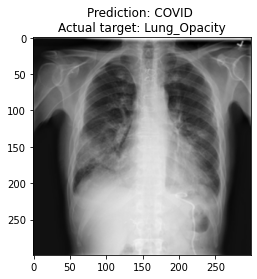

In [ ]:
from torch.autograd import Variable
import random
# Disable grad
with torch.no_grad():
  
  # Retrieve item
  index = random.randint(0,170)
  # index = 150
  item = val_data[index]
  image = item[0]
  true_target = item[1]

  saved_model.cuda()

  # Generate prediction
  image = image.unsqueeze(0)
  image = Variable(image)
  image = image.to(device)
  prediction = saved_model(image)

  # Predicted class value using argmax
  prediction = prediction.detach().cpu().numpy()
  print(categories)
  print(prediction[0])
  predicted_class = np.argmax(prediction)

  # Reshape image
  image.cpu().data.numpy()
  # image = image.reshape(28, 28, 1)

  # Show result
  plt.imshow(np.transpose(image.cpu().numpy().squeeze(), (1,2,0)))
  plt.title(f'Prediction: {categories[predicted_class]} \nActual target: {categories[true_target]}')
  plt.show()